In [90]:
#Import libraries
import numpy as np
import pandas as pd
import scanpy.api as sc
import anndata as ad
from scipy.sparse import csr_matrix
import logging
#from skbio.stats.composition import clr
#import doubletdetection
import matplotlib.pyplot as plt

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
results_file = '/Users/elizabeth/Documents/UCSF_Systems/Outputs/scanpy/10x_Algorithms_filtered_v1.h5ad'
#saveplat = '/Users/elizabeth/Documents/UCSF_Ye_lab-Mac/PCI/001-PCI-PrePilot/Outputs/scanpy/10x_PCI_nonorm_platelets.h5ad' 
sc.settings.set_figure_params(dpi=80)

scanpy==1.3.3 anndata==0.6.13 numpy==1.15.1 scipy==1.1.0 pandas==0.23.4 scikit-learn==0.20.0 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


In [91]:
#Load 10x data
#RNA
adata_rna = sc.read_10x_mtx('/Users/elizabeth/Documents/UCSF_Systems/data/JY_HG_01_PANC', var_names='gene_symbols', cache=True)
#Barcodes
adata_barcodes = sc.read_10x_mtx('/Users/elizabeth/Documents/UCSF_Systems/data/barcodes/raw_matrix', var_names='gene_symbols', cache=True)


... reading from cache file ./cache/Users-elizabeth-Documents-UCSF_Systems-data-JY_HG_01_PANC-matrix.h5ad
... reading from cache file ./cache/Users-elizabeth-Documents-UCSF_Systems-data-barcodes-raw_matrix-matrix.h5ad


In [92]:
#Filter adata_barcodes to just have barcodes called as cells from RNA
adata_barcodes_filtered = adata_barcodes[adata_rna.obs.index,:]
adata_barcodes_filtered

View of AnnData object with n_obs × n_vars = 4535 × 10 
    var: 'gene_ids', 'feature_types'

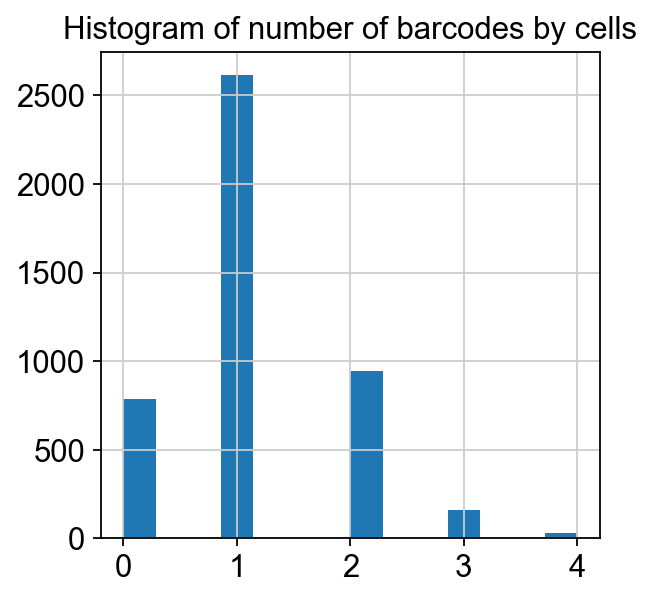

In [93]:
#Histogram of number of barcodes for each cell
non_zero_array = adata_barcodes_filtered.X > 0
barcodes_per_cell = np.sum(non_zero_array.toarray(), axis=1)
plt.hist(barcodes_per_cell, bins='auto')
plt.title("Histogram of number of barcodes by cells")
plt.show()

In [94]:
#Separate multiplets from adata barcode object
zeroes = barcodes_per_cell < 1
print("Discarding", np.sum(zeroes), "cells without a barcode")
multiplets = barcodes_per_cell > 1
adata_barcodes_multiplets = adata_barcodes_filtered[multiplets,:]
adata_barcodes_multiplets_array = adata_barcodes_filtered[multiplets,:].X.toarray()


Discarding 789 cells without a barcode


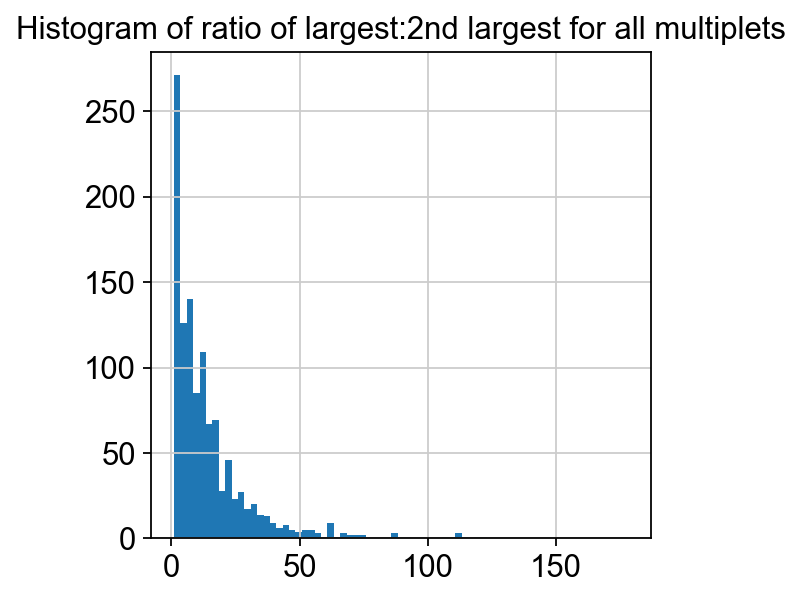

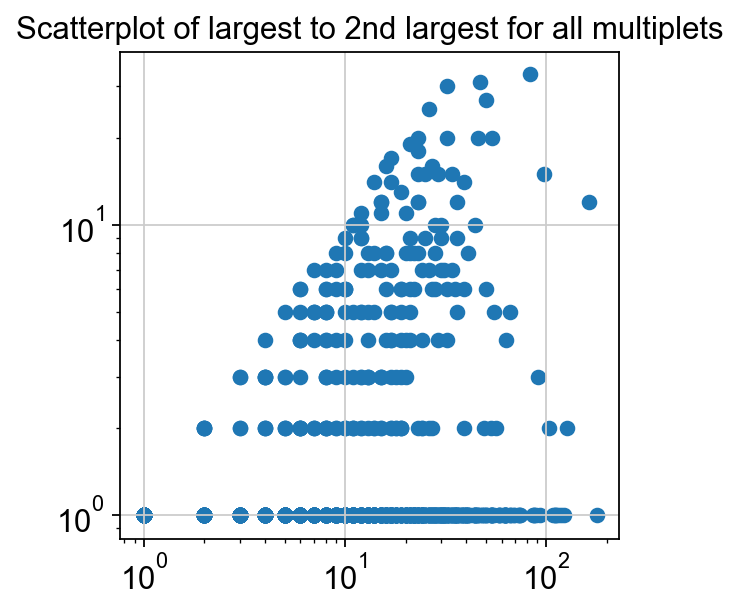

Discarding: 336 cells


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.


In [95]:
#Histogram
multiplet_ratio = []
for i in range(adata_barcodes_multiplets_array.shape[0]):
    ratio = sorted(adata_barcodes_multiplets_array[i,:])[-1]/np.sort(adata_barcodes_multiplets_array[i,:])[-2]
    multiplet_ratio.append(ratio)

plt.hist(multiplet_ratio, bins='auto')
plt.title("Histogram of ratio of largest:2nd largest for all multiplets")
plt.show()
#Scatterplot
highest_amt = []
lowest_amt = []
for i in range(adata_barcodes_multiplets_array.shape[0]):
    highest = np.sort(adata_barcodes_multiplets_array[i,:])[-1]
    lowest = np.sort(adata_barcodes_multiplets_array[i,:])[-2]
    highest_amt.append(highest)
    lowest_amt.append(lowest)
plt.scatter(highest_amt,lowest_amt)
plt.loglog()
plt.title("Scatterplot of largest to 2nd largest for all multiplets")
plt.show()

print("Discarding:",np.sum(i <5 for i in multiplet_ratio), "cells")

In [102]:
#Multiplets
multiplets_to_keep =  np.array(multiplet_ratio) >= 5
adata_barcodes_filtered_multiplets = adata_barcodes_multiplets[multiplets_to_keep,]
#Singlets
singlets = barcodes_per_cell == 1
adata_barcodes_filtered_singlets = adata_barcodes_filtered[singlets,]
#Combining
#adata_barcodes_to_keep = adata_barcodes_filtered_singlets.concatenate(adata_barcodes_filtered_multiplets)
barcodes_to_keep = adata_barcodes_filtered_singlets.obs.index.union(adata_barcodes_filtered_multiplets.obs.index)

In [103]:
barcodes_to_keep

Index(['AAACCTGAGAAGGCCT-1', 'AAACCTGAGCACACAG-1', 'AAACCTGCATCACGAT-1',
       'AAACCTGGTGACCAAG-1', 'AAACCTGTCCGTTGCT-1', 'AAACGGGAGGCTCAGA-1',
       'AAACGGGAGTAACCCT-1', 'AAACGGGAGTCTCAAC-1', 'AAACGGGCAAGAAGAG-1',
       'AAACGGGCACAACGCC-1',
       ...
       'TTTGGTTTCCCATTAT-1', 'TTTGGTTTCGTAGGTT-1', 'TTTGTCAAGCCGATTT-1',
       'TTTGTCACACATTCGA-1', 'TTTGTCACAGGAACGT-1', 'TTTGTCACAGGCGATA-1',
       'TTTGTCAGTGGTCTCG-1', 'TTTGTCAGTGTGGTTT-1', 'TTTGTCAGTTACCAGT-1',
       'TTTGTCATCGGCGCTA-1'],
      dtype='object', name=0, length=3410)

In [105]:
#Filtering RNA object
adata_rna = adata_rna[barcodes_to_keep,:]
adata_rna
#Filtering barcode object
adata_barcodes_filtered = adata_barcodes_filtered[barcodes_to_keep,:]
adata_barcodes_filtered

View of AnnData object with n_obs × n_vars = 3410 × 10 
    var: 'gene_ids', 'feature_types'

In [107]:
#Count number of ocurences for each type of cell and each replicate
test = np.array([adata_barcodes_filtered.var.index,]*3410)
barcodes_array = test[adata_barcodes_filtered.X.toarray() > 0]

unique, counts = np.unique(barcodes_array, return_counts=True)

print(np.array((unique, counts)).T)



[['BXPC3-LVM1-1' 190]
 ['BXPC3-LVM1-2' 252]
 ['BXPC3-LVM2-1' 49]
 ['BXPC3-LVM2-2' 283]
 ['BXPC3-P-1' 1260]
 ['BXPC3-P-2' 97]
 ['PANC1-LVM1-1' 661]
 ['PANC1-LVM1-2' 684]
 ['PANC1-P-1' 318]
 ['PANC1-P-2' 547]]


In [163]:
#Adding cell type identity to adata_rna object
adata_rna.obs['cell_type'] = barcodes_array

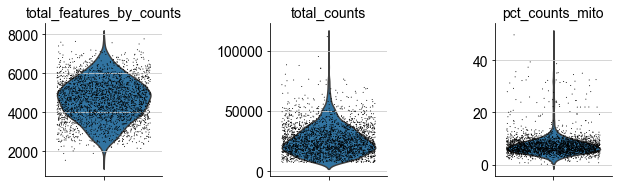

regressing out ['total_counts', 'pct_counts_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:06.64)


In [165]:
adata=adata_rna
#Calculate quality metrics
adata.var["mito"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, feature_controls=["mito"], inplace=True)
sc.pl.violin(adata, ['total_features_by_counts', 'total_counts', 'pct_counts_mito'],
             jitter=0.4, multi_panel=True)

#Filter cells by cells with min_genes > 100 and genes that appear in at least 3 cells
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)
#Filter cells by cells with % mito < 10
adata = adata[adata.obs['pct_counts_mito'] < 10, :]
# Filter cells with abnormally high gene counts.
#sc.pp.filter_cells(adata, max_genes=2500)
#Store raw data
adata.raw = adata
#Normalize gene counts
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
#Filter to highly variable genes
filter_result = sc.pp.filter_genes_dispersion(adata.X, log=True)
adata = adata[:, filter_result.gene_subset]
#Log trasnform data
sc.pp.log1p(adata)

#Regress out total_counts, 'pct_counts_mito', and 'batch'
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mito'])
#Scale expression data
sc.pp.scale(adata, max_value=10)

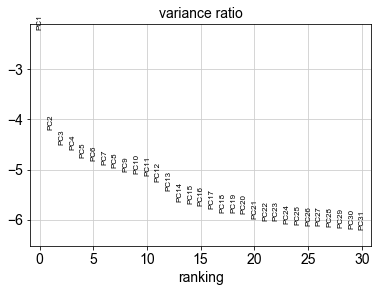

In [166]:
#Do PCA
adata.write(results_file)
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:03.33) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP


/usr/local/lib/python3.7/site-packages/scanpy/neighbors/umap/umap_.py:1173: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


    finished (0:00:04.61) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.18) --> found 11 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


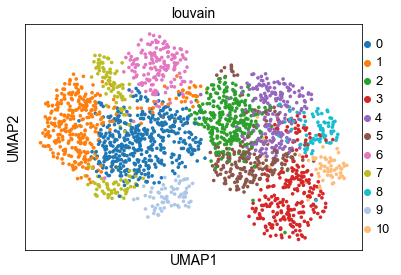

In [167]:
#Clustering and UMAP calculations
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)
sc.tl.umap(adata, min_dist = 2, gamma = 50)
sc.tl.louvain(adata)
sc.pl.umap(adata, color=['louvain'])

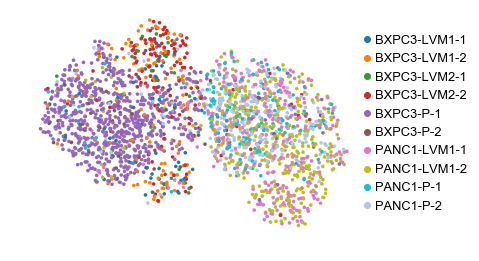

In [169]:
sc.pl.umap(adata, color='cell_type',title='', frameon=False)